<a href="https://colab.research.google.com/github/coding-dojo-data-science/machine-learning-practice-solutions/blob/main/Classification_Metrics_2_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://course_report_production.s3.amazonaws.com/rich/rich_files/rich_files/2470/s300/cd-logo-blue-600x600.png" alt="Coding Dojo Logo" class="center" height="50">

# Classification Metrics - Solutions
    
</center>

The data, which was modified from this source​, has information about direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. The goal is to predict if the client will subscribe (yes: 1 or no: 0) to a term deposit (the target column is called 'y_yes' in this csv).

Your task is to build a logistic regression model to predict whether or not a client will subscribe. Tune the hyperparameters to get the best model possible. Then, calculate the following classification metrics:

Metrics to calculate:
- Accuracy
- Sensitivity
- Specificity
- AUC ROC
- Additionally, plot the ROC.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
# import models
from sklearn.linear_model import LogisticRegression
# import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix

In [3]:
# load the dataset

df = pd.read_csv('/content/drive/MyDrive/Curriculum/DS 12wk 16 20 PT Curriculum/02: ML/07. Classification and KNN/data/bank_modified.csv')
df.head()

,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,y_yes
0,30,1787,79,1,-1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,33,4789,220,1,339,4,0,0,0,0,...,0,1,0,1,0,0,0,1,1,0
2,35,1350,185,1,330,1,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
3,30,1476,199,4,-1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,1,0
4,59,0,226,1,-1,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [4]:
# see distribution of target
df['y_yes'].value_counts(normalize = True)

0    0.88476
1    0.11524
Name: y_yes, dtype: float64

## Logistic Regression

In [5]:
# Arrange data into features matrix & target vector
X = df.drop(columns = 'y_yes')
y = df['y_yes']

In [6]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3, 
                                                   random_state=0, 
                                                   stratify=y)

Let's look at the distribution of our target variable for our testing set. Note: this is our baseline model! If we predicted everything to be in our majority class (in this case, 0), what percent would be get correct?

If we predict everything to be a 0, we would get 88.5% accuracy. That means that we need to get better than 88.5% accuracy to have a decent model.



In [7]:
# baseline model
y_test.value_counts(normalize = True)

0    0.885041
1    0.114959
Name: y_yes, dtype: float64

In [8]:
# Standardize Data
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# I'm going to use gridsearch to find the best hyperparameters for this model
# Feel free to research this on your own to learn more about this technique
params = {'penalty': ['l1', 'l2'],
          'C': [0.0001, 0.001, 0.01],
          'class_weight': [None, 'balanced']}

In [10]:
# logistic regression 
log_reg = LogisticRegression(solver = 'liblinear')

# grid search to find best hyperparameters
gs = GridSearchCV(log_reg, params, cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.0001, 0.001, 0.01],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']})

In [11]:
# here are the best hyperparameters based on the ones I tried
gs.best_estimator_

LogisticRegression(C=0.01, solver='liblinear')

In [12]:
# Accuracy:
print('Training accuracy:', gs.score(X_train, y_train))
print('Test accuracy:', gs.score(X_test, y_test))

Training accuracy: 0.8922250316055625
Test accuracy: 0.8872512896094326


In [13]:
# save predictions
preds = gs.predict(X_test)

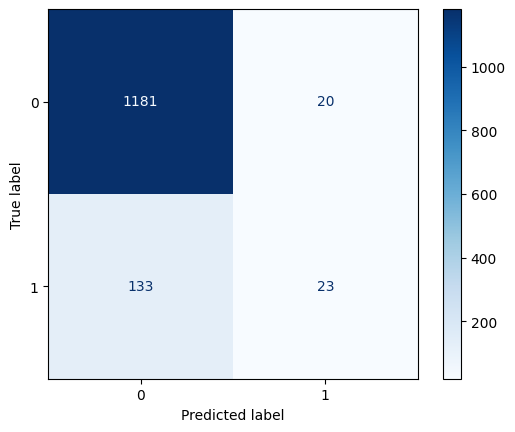

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'Blues');

In [15]:
# Sensitivity:

# Save confusion matrix:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

sensitivity = tp/ (tp + fn)

print('Sensitivity:', sensitivity)

Sensitivity: 0.14743589743589744


In [16]:
# Specificity:
specificity = tn / (tn + fp)

print('Specificity:', specificity)

Specificity: 0.9833472106577852


In [17]:
# AUC ROC Test
print('AUC ROC:', roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))

AUC ROC: 0.848625077392771


In [22]:
 # AUC ROC Train
print('AUC ROC:', roc_auc_score(y_train, gs.predict_proba(X_train)[:,1]))

AUC ROC: 0.8655547235558689


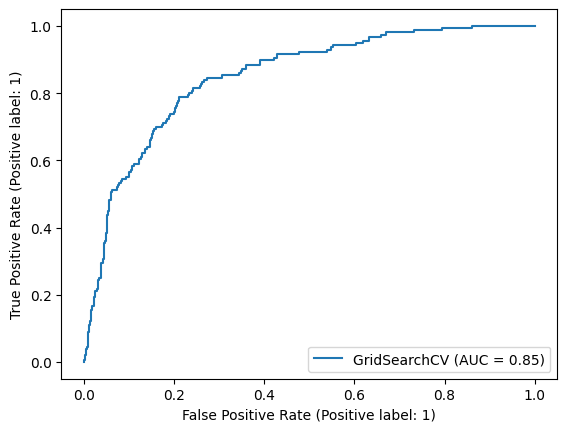

In [23]:
# Plot ROC curve Test
RocCurveDisplay.from_estimator(gs, X_test, y_test);

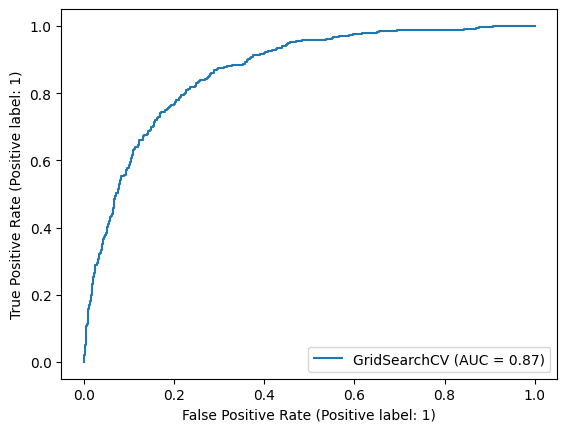

In [20]:
# Plot ROC curve Train
RocCurveDisplay.from_estimator(gs, X_train, y_train);

After you have completed the two tasks, answer the following questions. 

1. Which metric is going to be best to evaluate your classification models for this dataset and why? 
2. Compare your model's accuracy with the baseline model. Do you see any problems here?
3. What are other ways you could improve this model?

**1. Which metric is going to be best to evaluate your classification models for this dataset and why?**

It depends on the bank's goal. Overall, it is probably not the best idea to use accuracy as the evaluation metric for this task. The reason for this is because the data is super imbalanced. If I just predict that every customer will not subscribe, I will get 88.5% of the predictions correct. However, this is not at all helpful to the bank!  

Let's talk about sensitivity and specificity for this task. 

Sensitivity (the true positive rate) describes the percentage of customers that do subscribe that we correctly predicted would subscribe.
- high sensitivity = correctly predicting people that do subscribe
- low sensitivity = predicting people will not subscribe when they will  

A low sensitivity means we could potentially be missing out on customers who actually will subscribe but we predict they will not subscribe.

Specificity (the true negative rate) describes the percentage of customers that do not subscribe that we correctly predicted would not subscribe. 
- high specificity = correctly predicting people that do not subscribe
- low specificity = predicting people will subscribe when they do not

A low specificity means we could potentially be wasting marketing materials by marketing to people we predict will subscribe but they actually do not.

Because of this, the metric to optimize for depends on the bank's goal. We probably do not want to overlook customers that will end up subscribing, so optimizing for sensitivity makes sense in this case.

**2. Compare your model's accuracy with the baseline model. Do you see any problems here?**

My model's testing accuracy was 88.7% (0.8872512896094326).

The baseline accuracy was 88.5% (0.885041):

In [19]:
y_test.value_counts(normalize = True)

0    0.885041
1    0.114959
Name: y_yes, dtype: float64

This is not a great model because it is only slightly beating the baseline model!

**3. What are other ways you could improve this model?**

The main problem with this dataset is that it is super imbalanced. There are many techniques for dealing with imbalanced data that I encourage you to research on your own! Some techniques include:
- Optimize for a different metric when fitting the model
- Try a different algorithm
- Over or under sample the dataset to try to balance the target more
- use an algorithm like SMOTE